In [1]:
import gymnasium as gym
import numpy as np
import d3rlpy
import pickle

import matplotlib.pyplot as plt
from env.atari.represented_atari_game import GymCompatWrapper2
from online_main import OneHotWrapper
from utils import get_llm_data_paths
from vis_utils import *

hyperparams = {
    "env": "Pendulum-v1",  # MountainCar-v0, FrozenLake-v1, Pendulum-v1, CartPole-v0, CliffWalking-v0, RepresentedPong-v0
    "seed": 42069,
    # "n_episodes": 150,
    # "n_online_eps": 140,  # 10-5990 for mountainCar, 30-120 for CartPole
    # "n_pretrain_eps": 10,
    "max_episode_len": 200,  # Around 10h per 100k steps in Leviathan server
    "eps": 0.1,  # epsilon for exploration
    "n_exp": 5,
    "gpu": True,  # True if use GPU to train with d3rlpy
    "buffer_size": 100000,  # Test with 100k, 200k, 500k. 1M might be too much
    "data_path": None,  #'data/CartPole_Qwen2.5-7B-Instruct_Neps_10_20250406040150.pkl',
    "model_path": None,  #'d3rlpy_loss/DoubleDQN_online_20250331153346/model_600000.d3',
    "batch_size": 256,  # Test smaller batch size: 32, 64. May be noisier
    "learning_rate": 5e-5,
    "gamma": 0.99,
    "target_update_interval": 1000,  # Test with 1k, 2k, 5k
    "smooth": 10,  # For plotting, smooth the curve with this window size
    "sft": False, # Set to True to use SFT data paths
    "long_cot": False, # Set to True to use DeepSeek long CoT data paths
    "awac": False,
}

# Adjust n_episodes based on environment
env_name = hyperparams["env"].split("-")[0]
if env_name in ["CartPole", "FrozenLake"]:
    hyperparams["n_episodes"] = 150
elif env_name in ["Pendulum", "CliffWalking", "RepresentedPong"]:
    hyperparams["n_episodes"] = 200
elif env_name == "MountainCar":
    hyperparams["n_episodes"] = 300

max_n_pretrain_eps = 30

# assert (
#     hyperparams["n_episodes"]
#     == hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]
# ), "Check n_episodes=n_pretrain_eps+n_online_eps"

if "Represented" in hyperparams["env"]:
    env = GymCompatWrapper2(gym.make(hyperparams["env"]))
    eval_env = GymCompatWrapper2(gym.make(hyperparams["env"]))
elif isinstance(gym.make(hyperparams["env"]).observation_space, gym.spaces.Discrete):
    env = OneHotWrapper(gym.make(hyperparams["env"]))
    eval_env = OneHotWrapper(gym.make(hyperparams["env"]))
else:
    env = gym.make(hyperparams["env"])
    eval_env = gym.make(hyperparams["env"])

# fix seed
d3rlpy.seed(hyperparams["seed"])
d3rlpy.envs.seed_env(env, hyperparams["seed"])
d3rlpy.envs.seed_env(eval_env, hyperparams["seed"])

2025-09-19 11:44.29 [info     ] Register Shimmy environments. 


/opt/miniconda3/envs/llamagym/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Static/pretrain data

In [2]:
path_7b, path_32b = get_llm_data_paths(hyperparams["env"], hyperparams["sft"], hyperparams["long_cot"])

with open(path_7b, "rb") as file:
    Qwen_7B_dataset = pickle.load(file)
with open(path_32b, "rb") as file:
    Qwen_32B_dataset = pickle.load(file)

Qwen_32B_rewards = []
for i in range(max_n_pretrain_eps):
# for i in range(hyperparams["n_pretrain_eps"]):
    Qwen_32B_rewards.append(Qwen_32B_dataset.episodes[i].compute_return())
Qwen_7B_rewards = []
for i in range(max_n_pretrain_eps):
# for i in range(hyperparams["n_pretrain_eps"]):
    Qwen_7B_rewards.append(Qwen_7B_dataset.episodes[i].compute_return())

Qwen_7B = hyperparams["n_episodes"] * [np.mean(Qwen_7B_rewards)]
Qwen_32B = hyperparams["n_episodes"] * [np.mean(Qwen_32B_rewards)]

print("Qwen_32B: ", np.mean(Qwen_7B_rewards))
print("Qwen_7B: ", np.mean(Qwen_32B_rewards))

Qwen_32B:  -1607.0804700518722
Qwen_7B:  -1393.3942050072583


In [3]:
try:
    env_name = hyperparams["env"].split("-")[0]
    if env_name == "Pendulum":
        path_SFT = f"data/{env_name}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250422210707SFT.pkl"
    elif env_name == "CliffWalking":
        path_SFT = f"data/{env_name}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250505135458SFT.pkl"
        # path_SFT = f"data/{env_name}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250421175530SFT.pkl" #CliffWalking typo
    elif env_name == "FrozenLake":
        path_SFT = f"data/{env_name}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250501013018SFT.pkl"
        # path_SFT = f"data/{env_name}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250421120400SFT.pkl" #FrozenLake typo

    with open(path_SFT, "rb") as file:
        Qwen_7B_SFT_dataset = pickle.load(file)

    Qwen_7B_SFT_rewards = []
    for i in range(hyperparams["n_pretrain_eps"]):
        Qwen_7B_SFT_rewards.append(Qwen_7B_SFT_dataset.episodes[i].compute_return())
    Qwen_7B_SFT = Qwen_7B_SFT_rewards + hyperparams["n_online_eps"] * [
        np.mean(Qwen_7B_SFT_rewards)
    ]
    print("Qwen_7B_SFT: ", np.mean(Qwen_7B_SFT_rewards))
except:
    Qwen_7B_SFT = None
try:
    path_DS_7B = f"data/{hyperparams['env'].split('-')[0]}_DeepSeek-R1-Distill-Qwen-7B_Neps_{hyperparams['n_pretrain_eps']}_20250502071148.pkl"  # FrozenLake
    path_DS_14B = f"data/{hyperparams['env'].split('-')[0]}_DeepSeek-R1-Distill-Qwen-14B_Neps_{hyperparams['n_pretrain_eps']}_20250502084016.pkl"  # FrozenLake
    # path_DS_7B = f"data/{hyperparams['env'].split('-')[0]}_DeepSeek-R1-Distill-Qwen-7B_Neps_{hyperparams['n_pretrain_eps']}_20250419172821.pkl" #FrozenLake typo
    # path_DS_14B = f"data/{hyperparams['env'].split('-')[0]}_DeepSeek-R1-Distill-Qwen-14B_Neps_{hyperparams['n_pretrain_eps']}_20250422000525.pkl" #FrozenLake typo
    with open(path_DS_7B, "rb") as file:
        DS_7B_dataset = pickle.load(file)
    with open(path_DS_14B, "rb") as file:
        DS_14B_dataset = pickle.load(file)
    DS_7B_rewards = []
    for i in range(hyperparams["n_pretrain_eps"]):
        DS_7B_rewards.append(DS_7B_dataset.episodes[i].compute_return())
    DS_14B_rewards = []
    for i in range(hyperparams["n_pretrain_eps"]):
        DS_14B_rewards.append(DS_14B_dataset.episodes[i].compute_return())

    DS_7B = hyperparams["n_episodes"] * [np.mean(DS_7B_rewards)]
    DS_14B = hyperparams["n_episodes"] * [np.mean(DS_14B_rewards)]
    # DS_7B = DS_7B_rewards + hyperparams["n_online_eps"] * [np.mean(DS_7B_rewards)]
    # DS_14B = DS_14B_rewards + hyperparams["n_online_eps"] * [np.mean(DS_14B_rewards)]

    print("DS_7B: ", np.mean(DS_7B_rewards))
    print("DS_14B: ", np.mean(DS_14B_rewards))
except:
    DS_7B = None
    DS_14B = None

### Generate and evaluate random baseline

In [4]:
# Evaluate the random policy manually
random_rewards = []
for _ in range(max_n_pretrain_eps):
# for _ in range(hyperparams["n_pretrain_eps"]):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    count = 0
    while not done:
        action = env.action_space.sample()
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward
        count += 1
        if count >= hyperparams["max_episode_len"]:
            break
    random_rewards.append(total_reward)

mean_random = np.ones(
    # hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]
    hyperparams["n_episodes"]
) * np.mean(random_rewards)
# Print the average reward of the random policy
print(f"Average reward for random policy: {mean_random[0]}")

Average reward for random policy: -1199.8000837995532


# Plot

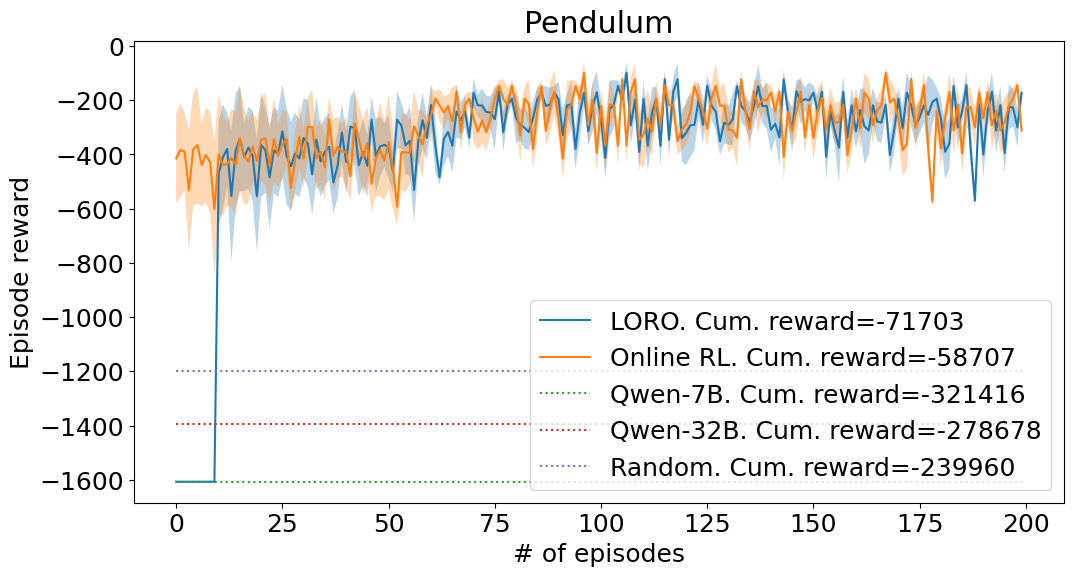

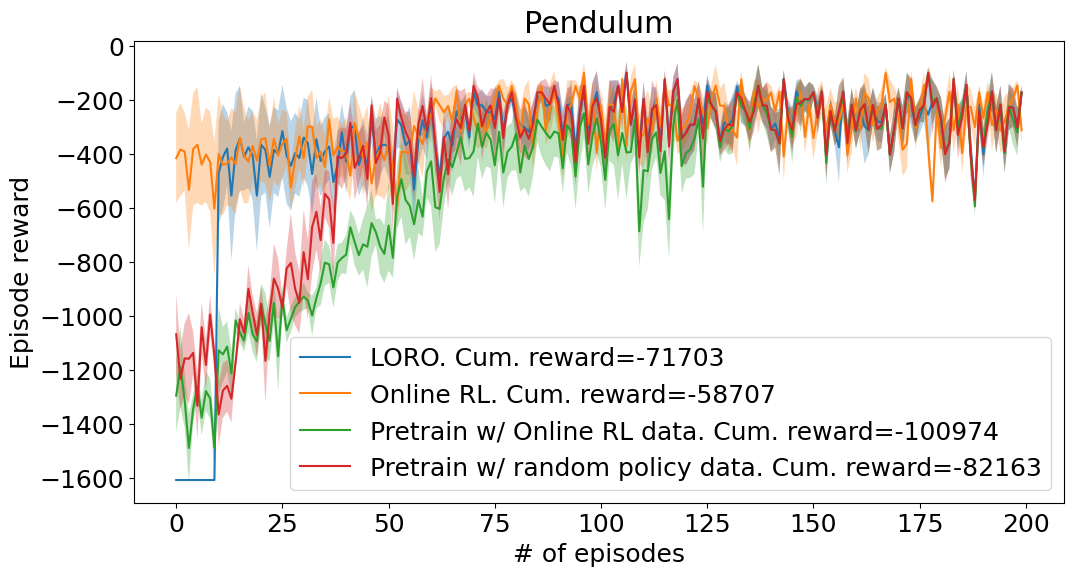

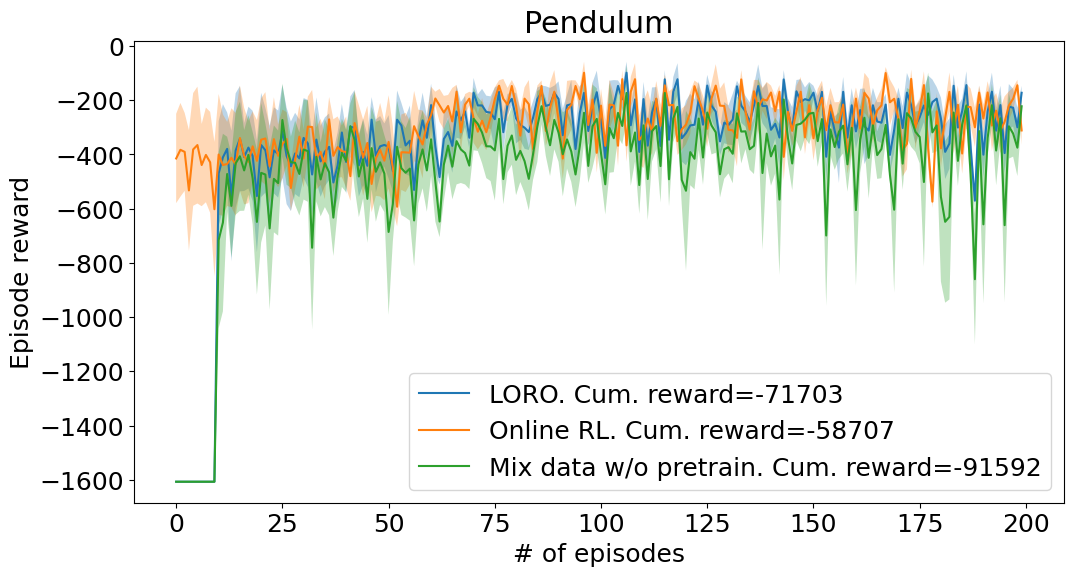

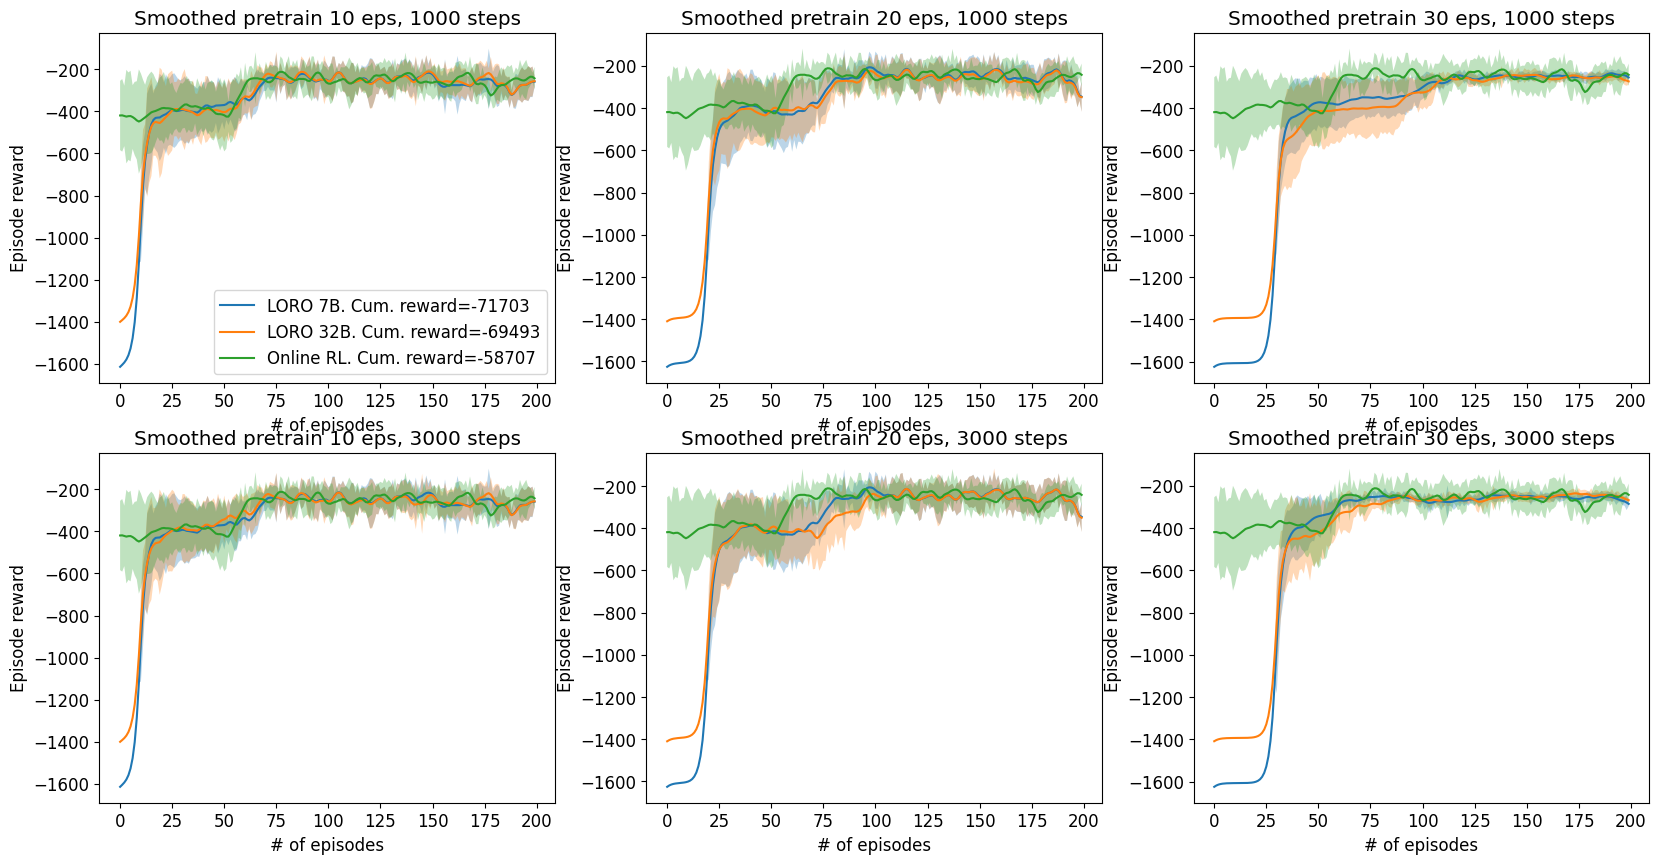

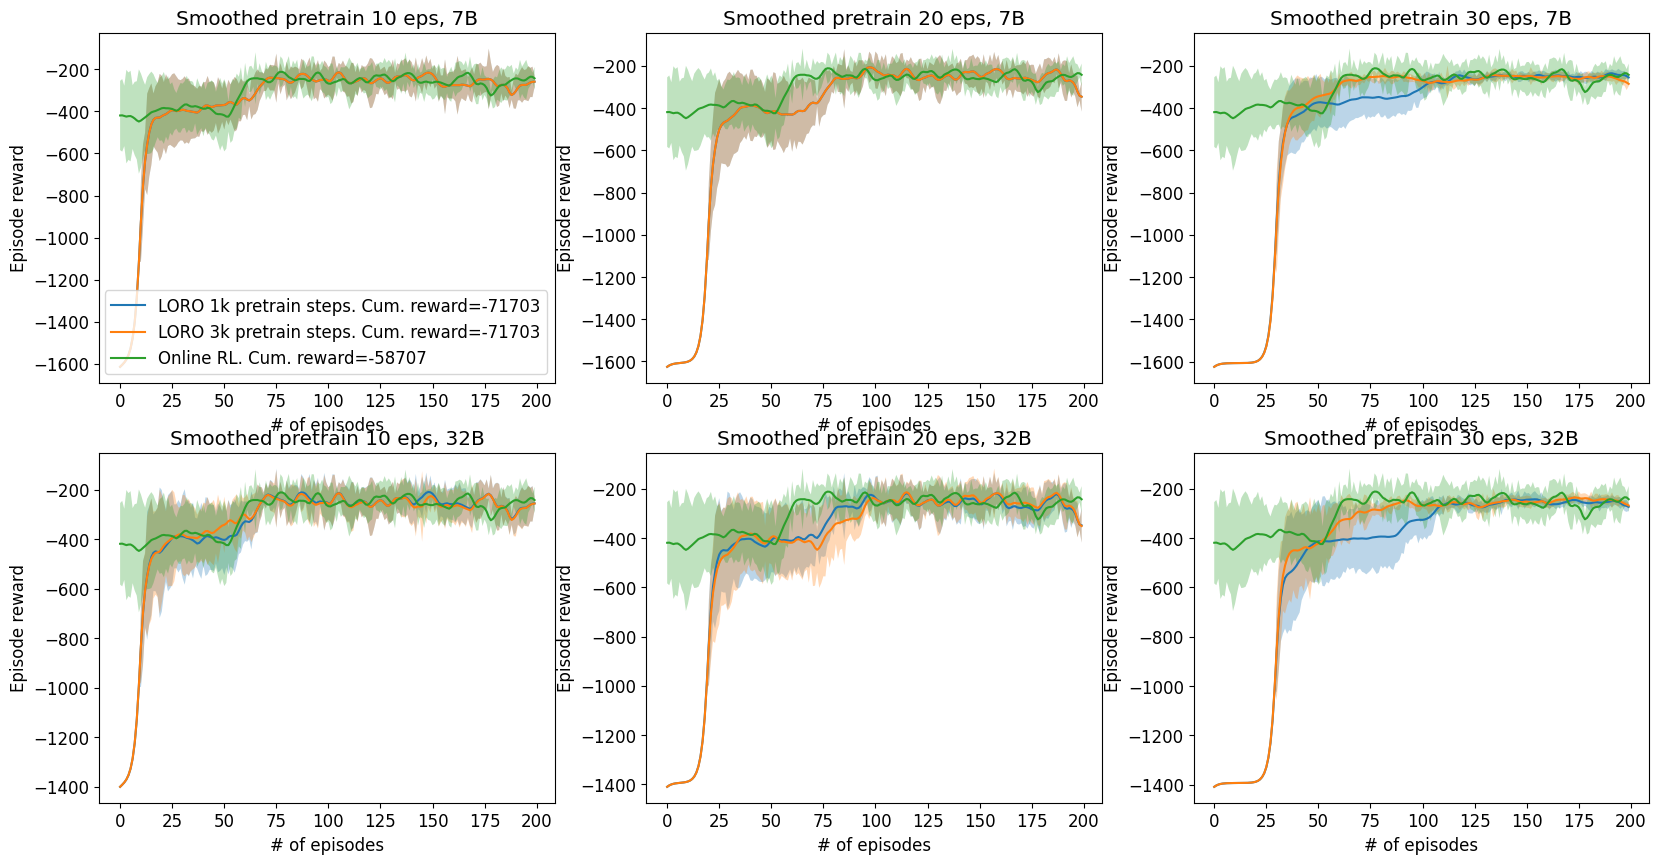

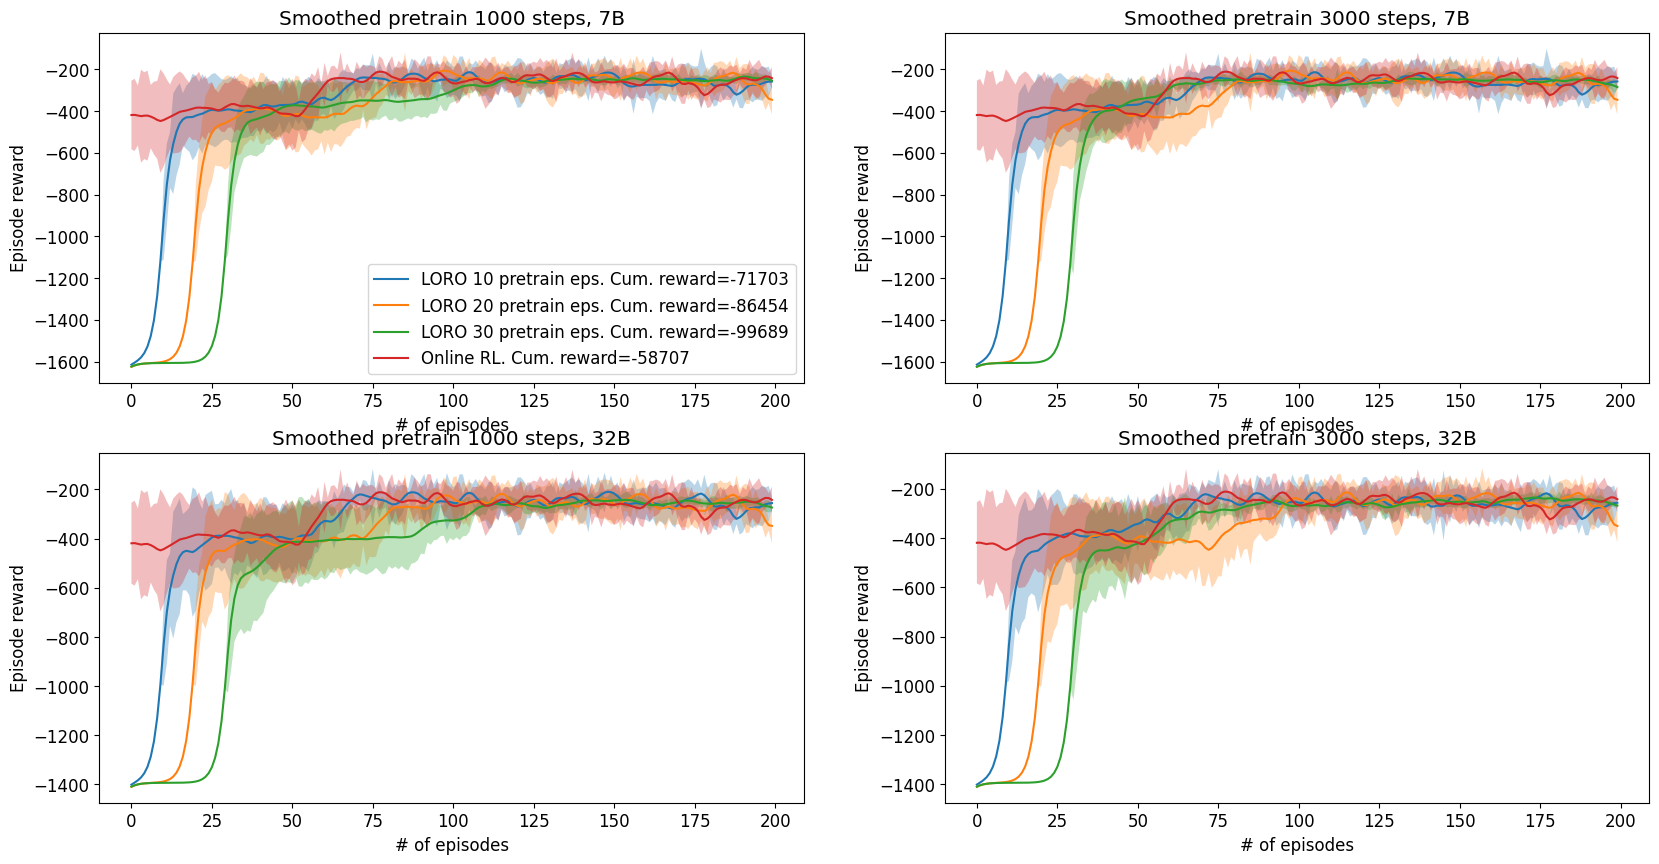

plot_sft_lcot_big


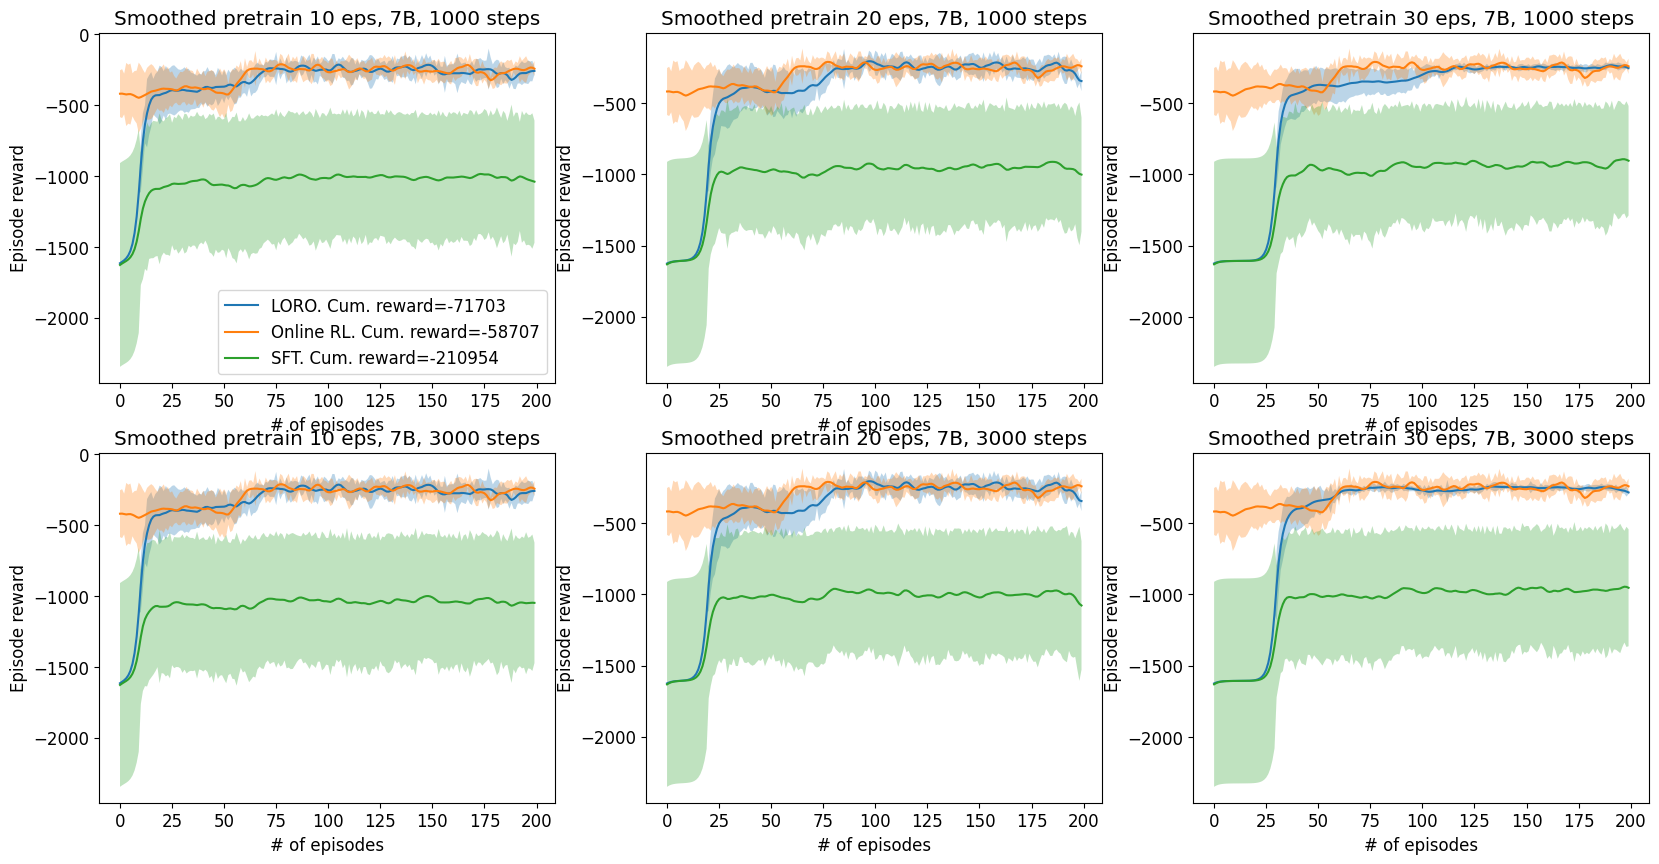

In [5]:
model_size = "7b"
all_cache = extract_data(hyperparams, Qwen_7B, Qwen_32B, DS_7B, DS_14B, mean_random, hyperparams["awac"])
plot_main(hyperparams, all_cache, Qwen_7B, Qwen_32B, mean_random, model_size)
plot_pretrain(hyperparams, all_cache, model_size)
plot_mix(hyperparams, all_cache, model_size)
plot_model_size(hyperparams, all_cache)
plot_pretrain_step(hyperparams, all_cache)
plot_pretrain_eps(hyperparams, all_cache)

# Only call plot_sft_lcot_big for specific environments
env_name = hyperparams["env"].split("-")[0]
if env_name in ['FrozenLake', 'CliffWalking', 'Pendulum'] and not hyperparams["awac"]:
    print("plot_sft_lcot_big")
    plot_sft_lcot_big(hyperparams, all_cache)

# plot_pretrain_big(hyperparams, all_cache)
# plot_sft_lcot(hyperparams, all_cache)